In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
df=pd.read_csv("./Data/SP_with_Mean_nd_Dev.csv")
df=df.sort_values('Time')


In [7]:
cols =[]
cols.append(list(df)[8])
cols.append(list(df)[44])
cols.append(list(df)[48])

In [8]:
df_for_training = df[cols].astype(float)

In [9]:
df_for_training 

,Speed(knots),Week_1_Mean,Week_1_SD
4975,25.0,302.770524,3.118572e-02
5493,25.0,301.916875,2.723977e-01
5494,25.0,301.916875,2.723977e-01
4996,25.0,302.750988,1.697182e-03
5476,30.0,301.916875,2.723977e-01
...,...,...,...
9131,25.0,302.877268,0.000000e+00
9132,25.0,302.877268,0.000000e+00
9133,20.0,302.948860,5.684342e-14
9263,20.0,302.942001,0.000000e+00


<AxesSubplot:>

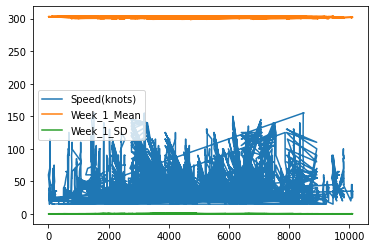

In [10]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()


In [11]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [12]:
df_for_training_scaled

array([[-0.83468119,  0.68519123, -0.78895789],
       [-0.83468119, -0.36613903,  1.3803383 ],
       [-0.83468119, -0.36613903,  1.3803383 ],
       ...,
       [-1.02575061,  0.9048249 , -1.06942098],
       [-1.02575061,  0.89637745, -1.06942098],
       [-0.83468119,  0.87948256, -1.06942098]])

In [13]:
X = []
Y = []

n_future = 1 
n_past = 14  #total past days
train_size=8000
test_size=len(df)-train_size-n_past

for i in range(n_past, len(df) - n_future +1):
    X.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    Y.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

X, Y = np.array(X), np.array(Y)

print('X shape == {}.'.format(X.shape))
print('Y shape == {}.'.format(Y.shape))

X shape == (10148, 14, 3).
Y shape == (10148, 1).


In [14]:
x_train=X[:train_size]
y_train=Y[:train_size]
x_test=X[train_size:]
y_test=Y[train_size:]
print(x_train.shape)
print(y_train.shape)


(8000, 14, 3)
(8000, 1)


In [15]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))


model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(x_train, y_train, epochs=10, batch_size=1, validation_split=0.1, verbose=2)

Epoch 1/10
7200/7200 - 14s - loss: 0.2377 - accuracy: 0.0000e+00 - val_loss: 0.1910 - val_accuracy: 0.0000e+00
Epoch 2/10
7200/7200 - 14s - loss: 0.1984 - accuracy: 0.0000e+00 - val_loss: 0.1324 - val_accuracy: 0.0000e+00
Epoch 3/10
7200/7200 - 14s - loss: 0.1854 - accuracy: 0.0000e+00 - val_loss: 0.1374 - val_accuracy: 0.0000e+00
Epoch 4/10
7200/7200 - 14s - loss: 0.1759 - accuracy: 0.0000e+00 - val_loss: 0.1330 - val_accuracy: 0.0000e+00
Epoch 5/10
7200/7200 - 14s - loss: 0.1748 - accuracy: 0.0000e+00 - val_loss: 0.1354 - val_accuracy: 0.0000e+00
Epoch 6/10
7200/7200 - 14s - loss: 0.1691 - accuracy: 0.0000e+00 - val_loss: 0.1359 - val_accuracy: 0.0000e+00
Epoch 7/10
7200/7200 - 14s - loss: 0.1649 - accuracy: 0.0000e+00 - val_loss: 0.1571 - val_accuracy: 0.0000e+00
Epoch 8/10
7200/7200 - 14s - loss: 0.1697 - accuracy: 0.0000e+00 - val_loss: 0.1644 - val_accuracy: 0.0000e+00
Epoch 9/10
7200/7200 - 14s - loss: 0.1580 - accuracy: 0.0000e+00 - val_loss: 0.1426 - val_accuracy: 0.0000e+00
E

In [40]:
train_dates=df['Time'][-test_size:].tolist()
print(len(train_dates))
#predict_period_dates = pd.date_range(list(train_dates)[-200], periods=n_future, freq='1d').tolist()
prediction = model.predict(x_test)

2148


In [41]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

copies = np.repeat(y_test, df_for_training.shape[1], axis=-1)
y_future = scaler.inverse_transform(copies)[:,0]

In [42]:
forecast_dates = []
original=df['Speed(knots)'][-test_size:]
for time_i in train_dates:
    forecast_dates.append(time_i)

    
print(len(original))
print(len(forecast_dates))
print(len(y_pred_future))
    
df_forecast = pd.DataFrame({'Time':(forecast_dates), 'Speed':y_pred_future,'Original_speed':original})


2148
2148
2148


In [43]:
df_forecast

,Time,Speed,Original_speed
2137,2011-01-22 00:00:00,29.554260,35
2136,2011-01-22 06:00:00,34.217346,40
2135,2011-01-22 12:00:00,41.923592,50
2661,2011-01-22 12:00:00,55.344925,25
2113,2011-01-22 18:00:00,29.832327,50
...,...,...,...
9131,2019-05-15 18:00:00,24.513407,25
9132,2019-05-16 00:00:00,23.807495,25
9133,2019-05-16 06:00:00,27.289831,20
9263,2019-05-16 12:00:00,22.216642,20


C:\Users\yueqi\AppData\Roaming\Python\Python36\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\yueqi\AppData\Roaming\Python\Python36\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Time', ylabel='Original_speed'>

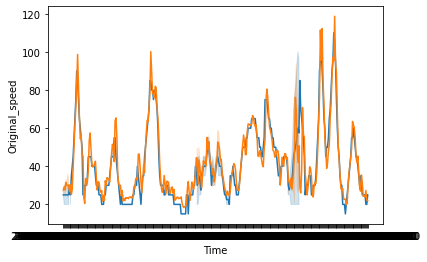

In [44]:
original = df_forecast[1750:]
original
#original = original.loc[original['Time'] >= '2019-1-1']
#original['Time']=pd.to_datetime(original['Time'])



sns.lineplot(original['Time'], original['Original_speed'])
sns.lineplot(original['Time'], original['Speed'])




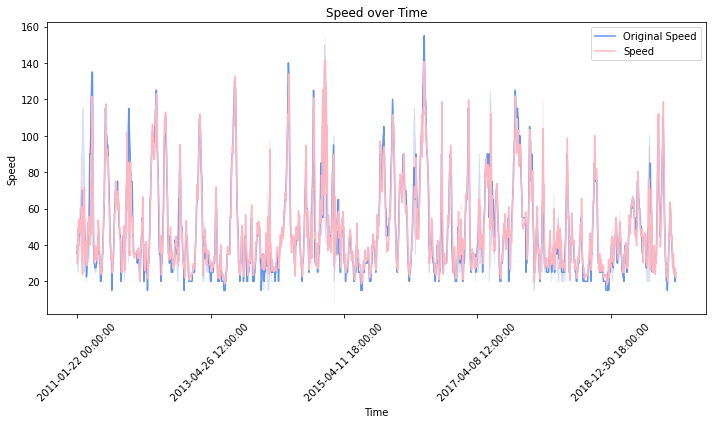

In [48]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting the original and speed data
sns.lineplot(data=df_forecast, x='Time', y='Original_speed', label='Original Speed', color='cornflowerblue')
sns.lineplot(data=df_forecast, x='Time', y='Speed', label='Speed', color='lightpink')

# Customize x-axis ticks
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjust x-axis ticks frequency
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Set maximum of 6 ticks, adjust as needed

plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Speed over Time')

plt.legend()
plt.tight_layout()
plt.savefig("./Results_plots/windspeed_predict.pdf")
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_actual=np.array(df_forecast['Original_speed'])
y_predicted=np.array(df_forecast['Speed'])
y_actual=y_actual.reshape(2148,1)
y_predicted=y_predicted.reshape(2148,1)


In [31]:
print(r2_score(y_actual,y_predicted))
print(mean_absolute_error(y_actual,y_predicted))

0.7460844866802837
8.15648375676331
